[1.86309922 0.44018652 0.68512564 0.30887808 0.38651364 0.26322401
 0.02854894 0.9355819  0.92994471 0.27665636 0.54229631 0.26926373
 0.16030615 0.16850249 0.66826572 0.05485164 0.42290354 0.95327103
 0.25635737 0.4129347 ]
1.0
[0.88621529 0.88913347 1.        ]


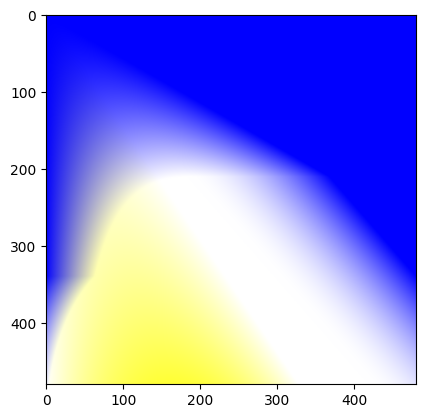

In [19]:
import grn
import numpy as np
import matplotlib.pyplot as plt
from genome import *



nin = 2
nout = 3
nreg = 1

genome = random_genome(nin, nout, nreg)
print(genome)

gsquare = grn.GRN(genome)
gsquare.random(nin=nin, nout=nout, nreg=nreg)

N = 480


matrix = np.zeros((N,N,3))
gsquare.step(25)
for i in range(N):
    for j in range(N):
        gsquare.set_input([i/N, j/N])
        gsquare.step(2)   
        out = gsquare.get_output()
        # if max(out) > 1:
        #     print("wtf")
        # print(out)
        matrix[i][j] = out


print(np.max(matrix))
plt.imshow(matrix)

print(out)
# plt.savefig("test.png")

In [ ]:
from grn import GRN
import matplotlib.pyplot as plt



nin = 2
nout = 3
nreg = 1

genome = random_genome(nin, nout, nreg)
gsquare = grn.GRN(genome)

print(gsquare.genome)
gsquare.reset()

gsquare.step(nsteps=25)

outputs = []
outputs.append(gsquare.get_output())


for i in range(1000):
    # g.set_input([0.5, 0.5])
    gsquare.set_input([0.1])
    gsquare.step()
    outputs.append(gsquare.get_output())
    # print(g.concentrations)

plt.plot(outputs)

In [ ]:
print("grn concentrations summ should be  1 : ", np.sum(gsquare.concentrations[nin:]))
print("grn concentrations ", gsquare.concentrations)
print("grn genome ", gsquare.genome)
print("len genome ",len(gsquare.genome))


In [ ]:
import matplotlib.pyplot as plt 

tg = GRN()
gsquare.reset()

tg.from_genome(gsquare.genome)
tg.from_genome_cmaes(es.best.x)
# tg.random(nin=n_in, nout=n_out, nreg=10)
print(es.best.x)

yg = problem.run_grn(gsquare)
ytg = problem.run_grn(tg)
# ytg = problem.run_grn(r)
# problem.run_grn(g)
plt.plot(xtrain, yg, label="grn")
plt.plot(xtrain, ytg, label="tg")
plt.plot(xtrain, ytrain, label = "target")

err = np.linalg.norm(ytrain - np.array(ytg))
print("err", err)
plt.legend()
# g.from_genome_cmaes(cma_result[0])
# print(tg)
# print("best grn fit: ", problem.run_grn(tg.genome))

# DEAP test 

In [ ]:
import random
from deap import base, creator, tools, algorithms




# 1. Define the fitness and individual types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

# 2. Set up the toolbox (genetic operators)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)  # Gene: random float in [0, 1]
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_float,
    n=5  # Genome length = 5
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    return sum(individual),

# 3. Define genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover (blend parents)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=0.0, up = 1.0, indpb=0.1)  # Mutation
toolbox.register("select", tools.selTournament, tournsize=3)  # Selection
toolbox.register("evaluate", evaluate)  # Fitness = sum of genome values

# 4. Create population and run the GA
population = toolbox.population(n=50)  # 50 individuals
algorithms.eaSimple(
    population,
    toolbox,
    cxpb=0.0,       # Crossover probability
    mutpb=0.2,      # Mutation probability
    ngen=100,        # Generations
    verbose=True    # Print progress
)

# 5. Print the best solution
best_individual = tools.selBest(population, k=)[0]
print(f"\nBest genome: {best_individual}")
print(f"Best fitness (sum): {best_individual.fitness.values[0]}")

In [ ]:
from pathlib import Path
import sys
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import random
from deap import base, creator, tools, algorithms
import numpy as np
from grn import GRN
import problem as p 
import matplotlib.pyplot as plt
from genome import random_genome
from mutation import *
from crossover import *
from functools import partial

# grn hyperparameters 
nin = 1
nout = 2
nreg = 0

a = 1
f = 0

size = nin + nout + nreg
genome_size = size*3 + 2 # 2 for beta and delta

# create the problem instance 
t = np.linspace(0, 1, 500)
xtrain = t
ytrain = [np.array(xtrain), np.sin(xtrain*10)**2] # 
# ytrain = t


# genome_size = random_genome(nin, nout, nreg).size
problem = p.RegressionProblem(xtrain, ytrain, nin, nout, nreg)
# problem = p.FrenchFlagProblem(nin=nin, nout=nout, nreg=nreg)


def evaluate(individual):
    fit, _ = problem.eval(individual)
    return fit,

# 1. Define the fitness and individual types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize fitness
creator.create("Individual", list, fitness=creator.FitnessMax)


def init_indiv(nin, nout, start_nreg):
    return random_genome(nin, nout, start_nreg)

init_indiv_fun = partial(init_indiv, nin=nin, nout=nout, start_nreg=nreg)
# 2. Set up the toolbox (genetic operators)
toolbox = base.Toolbox()
toolbox.register("individual",tools.initIterate, creator.Individual,init_indiv_fun,)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 3. Define genetic operators
# toolbox.register("mate", tools.crossover, nin=nin, nout=nout)  # Crossover (blend parents)

toolbox.register("mate", tools.cxBlend, alpha = 1.0)  # Crossover (blend parents)
toolbox.register("mutate", mutate, nin=nin, nout=nout, betamin=0.2, betamax=2, deltamin=0.2, deltamax=2)  # Mutation
# toolbox.register("mutate", lambda individual: tools.mutGaussian(individual, mu=0, sigma=0.5, indpb=0.5))  # Mutation

toolbox.register("select", tools.selTournament, tournsize=3)  # Selection
toolbox.register("evaluate", evaluate)  # Fitness = sum of genome values

population = toolbox.population(n=1000)  # 50 individuals
hof = tools.HallOfFame(1)  # Track best individual

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_fit.register("avg", np.mean)
stats_fit.register("min", np.min)
stats_fit.register("max", np.max)


algorithms.eaMuPlusLambda(
    population,
    toolbox,
    lambda_=750,
    mu=250,
    cxpb=0.3,       # Crossover probability
    mutpb=0.7,      # Mutation probability
    ngen=10,        # Generations
    halloffame=hof,
    stats=stats_fit,
    verbose=True    # Print progress
)

# 5. Print the best solution
best_individual = tools.selBest(population, k=1)[0]
print(f"\nBest genome: {len(best_individual)}")
print(f"Best fitness (sum): {best_individual.fitness.values[0]}")


ImportError: attempted relative import with no known parent package

error on problem -37.94235151859454


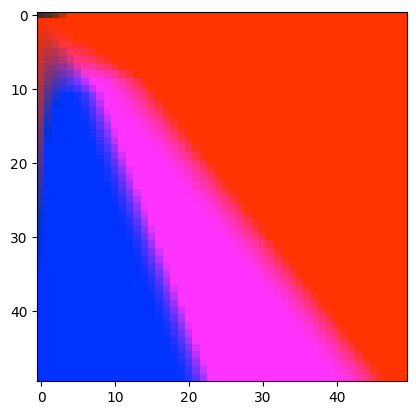

In [4]:
grn = GRN(best_individual, nin=1, nout=1)
# grn.setup()

t = np.linspace(0, 1, 500)

err, ypred = problem.eval(best_individual)
# grn.setup()
# grn.reset()
# grn.warmup(25)
# y=  []
# for ti in t:
#     grn.set_input([ti])
#     grn.step()
#     y.append(grn.get_output())
# print(grn.concentrations)

# plt.plot(t, y[:])
# plt.plot(t, np.sin(t)**2)
# plt.show()

plt.imshow(ypred)
# plt.plot(t, ypred,)
# # plt.plot(t, np.sin(t**10)**2)
# plt.plot(t, problem.ytrain)
# np.sum(abs(ypred-problem.ytrain))


# print("error on test set", np.sum(abs(ypred-problem.ytrain)))
print("error on problem", err)
# np.linalg.norm(ypred - np.sin(t)**2)
# np.linalg.norm(y[:] - np.sin(t)**2)

In [ ]:
len(best_individual), best_individual

print("best_individual", best_individual)
print(grn)

[0.2 0.2 0.2 0.2 0.2]
5
concentration after warmup [0.         0.45259131 0.         0.         0.9327978 ]
{'nin': 1, 'nout': 1, 'nreg': 3, 'beta': 0.9116682507312829, 'delta': 1.8735, 'a': 0, 'f': 1, 'idsize': 1.0, 'identifiers': array([0.32002262, 0.53875186, 0.30636835, 0.13747037, 0.97652842]), 'enhancers': array([0.48307438, 0.48090997, 0.7544553 , 0.74180602, 0.37003506]), 'inhibiters': array([0.98429017, 0.76989283, 0.84782954, 0.90306246, 0.57703009])}
enh matrix  [[0.35714815 0.30327436 0.36451054 0.46537989 0.56844835]
 [0.35599184 0.30429112 0.36333567 0.46397214 0.57005546]
 [0.52569548 0.38618598 0.53540004 0.6643495  0.38981802]
 [0.51680683 0.37904973 0.52640589 0.65415666 0.39710734]
 [0.30062632 0.36018852 0.30704131 0.39585671 0.65588967]]
inh matrix shape  [[0.70313635 0.53358003 0.71452899 0.86125126 0.2814735 ]
 [0.53667582 0.39503314 0.54650795 0.67689626 0.38105993]
 [0.59427475 0.44202219 0.60472603 0.74191436 0.33914076]
 [0.63718021 0.47767056 0.6480382  0.78

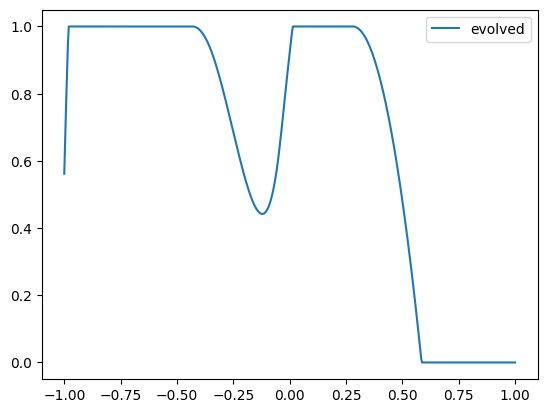

In [4]:
import numpy as np
from grn import GRN
from genome import *   
import matplotlib.pyplot as plt

# grn evolved with great from pygnr should looks like a square 


beta = 0.9116682507312829
delta = 1.8735
identifiers = [0.32002262, 0.53875186, 0.30636835, 0.13747037, 0.97652842]
enhancers = [0.48307438, 0.48090997, 0.7544553 , 0.74180602, 0.37003506]
inhibiters = [0.98429017, 0.76989283, 0.84782954, 0.90306246, 0.57703009]
a = 0
f = 0
genome = encode_genome(beta, delta, identifiers, enhancers, inhibiters)
gsquare = GRN(genome, nin=1, nout=1)

t = np.linspace(-1, 1, 500)

gsquare.setup()

print(gsquare.concentrations)
gsquare.warmup(25)
print(gsquare.size)
print("concentration after warmup", gsquare.concentrations)
ys = []
for ti in t:
    gsquare.set_input([ti])
    gsquare.step()
    ys.append(gsquare.get_output())


plt.plot(t, ys, label="evolved")
# plt.plot(t, ytrain, '.', label = "target")
plt.legend()

print(gsquare)
print("enh matrix ", gsquare.enh_affinity_matrix)
print("inh matrix shape ", gsquare.inh_affinity_matrix)

In [3]:
print(gsquare.genome)

gtest = GRN()
gtest.random(nin=1, nout=1, nreg=3)
gsquare_genome = gsquare.genome
gtest.from_genome(gsquare.genome)

gtest.warmup(25)
print(gtest.size)
print("concentration after warmup", gsquare.concentrations)
yss = []
for ti in t:
    gtest.set_input([ti])
    gtest.step()
    yss.append(gtest.get_output())


plt.plot(t, ys, '.' , label="evolved")
plt.plot(t, yss, '.', label="evolved")
# plt.plot(t, ytrain, '.', label = "target")
plt.legend()

NameError: name 'gsquare' is not defined

In [ ]:
def french_flag(N):
    """
    Create a NxNx3 matrix representing the French flag.
    
    Blue | White | Red
    """
    flag = np.zeros((N, N, 3), dtype=np.uint8)  # RGB uint8 values 0-255

    # Width of each stripe
    stripe_width = N // 3

    # Blue stripe
    flag[:, :stripe_width, :] = [0, 85, 164]  # RGB for blue

    # White stripe
    flag[:, stripe_width:2*stripe_width, :] = [255, 255, 255]

    # Red stripe
    flag[:, 2*stripe_width:, :] = [239, 65, 53]  # RGB for red

    return flag/255.0

# Example usage
N = 50
flag = french_flag(N)
plt.imshow(flag)


def eval(individual):
    fit, _ = problem.eval(individual)
    return fit,

/home/jmartinsaquet/.pyenv/versions/smartdart3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/jmartinsaquet/.pyenv/versions/smartdart3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	min     	max     	std    
0  	500   	-1845.94	-1887.43	-1623.46	36.6931
1  	500   	-1816.43	-1887.11	-1770.01	18.3112
2  	500   	-1798.7 	-1834.38	-1707.39	24.516 
3  	500   	-1776.94	-1831.47	-1690.78	33.9637
4  	500   	-1749.52	-1813.88	-1635.27	40.5146
5  	500   	-1722.99	-1809.97	-1579.12	37.6908
6  	500   	-1672.77	-1771.97	-623.242	115.916
7  	500   	-1629.63	-1739.18	-623.242	113.259
8  	500   	-1548.23	-1707.39	-623.242	217.086
9  	500   	-1407.99	-1807.51	-623.242	358.032
10 	500   	-1186.56	-1807.51	-623.242	452.035
11 	500   	-961.048	-1788.78	-623.242	442.613
12 	500   	-697.311	-1754.17	-623.242	252.297
13 	500   	-623.242	-623.242	-623.242	2.27374e-13
14 	500   	-623.242	-623.242	-623.242	2.27374e-13
15 	500   	-623.242	-623.242	-623.242	2.27374e-13
16 	500   	-623.242	-623.242	-623.242	2.27374e-13
17 	500   	-624.723	-771.256	-623.242	14.7271    
18 	500   	-623.242	-623.242	-623.242	2.27374e-13
19 	500   	-623.242	-623.242	-623.242	2.27374e-13
20 	50

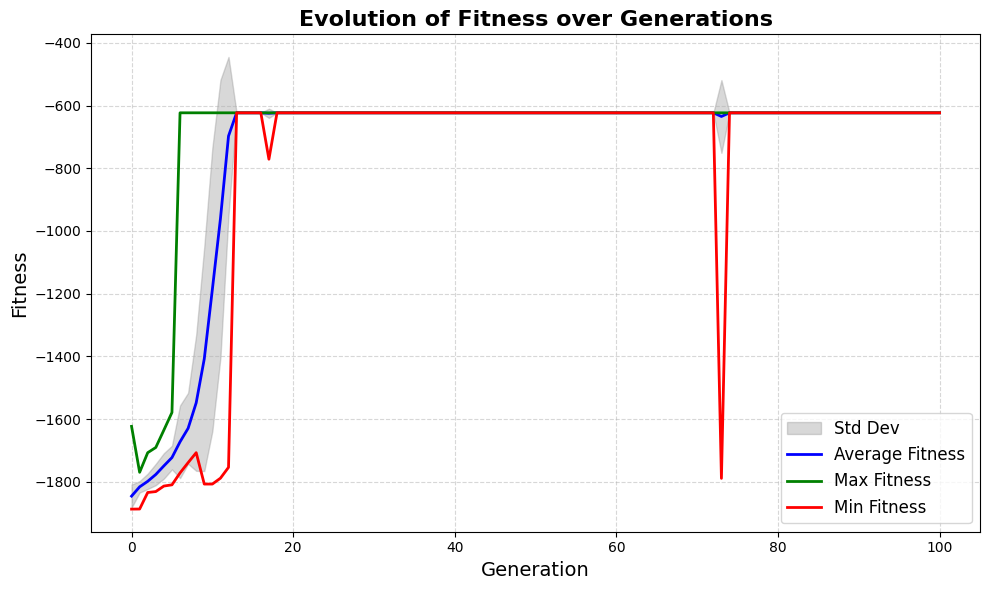

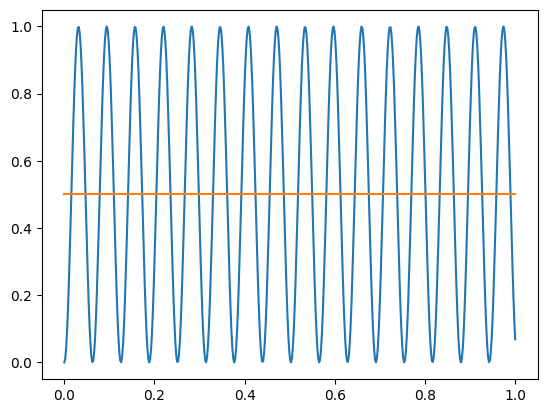

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from evolver import *
from genome import *
from problem import *
from grn import *

t = np.linspace(0, 1, 500)
ytrain = np.sin(t*50)**2
p = RegressionProblem(t, ytrain, nin=1, nout=1, nreg=0)


e = EATMuPlusLambda(nin=1, nout=1, nreg=0)
alg = e.run(100, p, 100, 500, verbose=True)
e.visualize_evolutions()
alg[0][0]

g = GRN(alg[0][0], nin=1, nout=1)
p.run_grn(g)

plt.plot(t, ytrain)
plt.plot(t, p.run_grn(g))

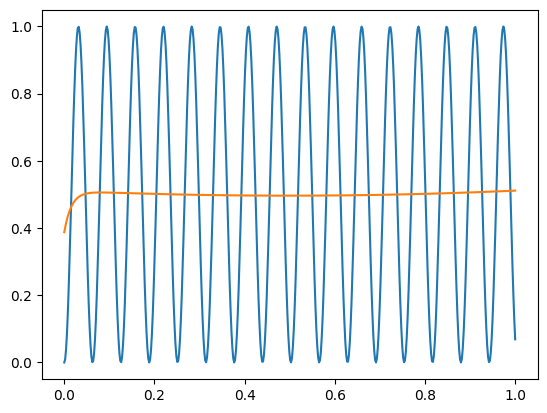